# Dataset Preparation for Code Autocomplete Assistant

This notebook handles downloading and preparing datasets for training:

- CodeSearchNet dataset for general comment-to-code capability
- AWS CDK examples for domain adaptation

This notebook handles downloading and preparing all datasets for training
:
- **CodeSearchNet**: Python and JavaScript for general code understanding
- **AWS CDK Examples**: Python and TypeScript CDK constructs
- **FIM Generation**: Creates Fill-in-the-Middle training samples (80%)
- **Comment-to-Code**: Creates instruction-based samples (20%)

In [1]:
# Imports
import sys
import subprocess
import tempfile
from pathlib import Path
from typing import Dict, List, Any
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.config import DATASETS_DIR, STAGE_A_DIR, STAGE_B_DIR, UNIFIED_DIR, SEED

from datasets import load_dataset

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [3]:
from src.data_processing import (
    create_mixed_dataset,
    extract_python_examples,
    extract_typescript_examples,
    split_and_save_examples,
    load_train_val_data,
    save_datasets
)

## Configuration and Setup

In [4]:
# Dataset configuration
STAGE_A_DIR.mkdir(exist_ok=True, parents=True)
STAGE_B_DIR.mkdir(exist_ok=True, parents=True)
UNIFIED_DIR.mkdir(exist_ok=True, parents=True)

print(f"Datasets directory: {DATASETS_DIR}")
print(f"Project root: {project_root}")
print(f"Stage_A output directory: {STAGE_A_DIR}")
print(f"Stage_B output directory: {STAGE_B_DIR}")
print(f"Unified output directory: {UNIFIED_DIR}")

Datasets directory: /storage/homefs/ai22t082/code_complete/datasets
Project root: /storage/homefs/ai22t082/code_complete
Stage_A output directory: /storage/homefs/ai22t082/code_complete/datasets/stage_a
Stage_B output directory: /storage/homefs/ai22t082/code_complete/datasets/stage_b
Unified output directory: /storage/homefs/ai22t082/code_complete/datasets/unified


In [5]:
# Sampling configuration
PYTHON_SAMPLES = 10000
JS_SAMPLES = 10000
FIM_RATIO = 0.5  # 50% FIM, 50% comment-to-code
FIM_SAMPLES_PER_CODE = 10

## Stage A: CodeSearchNet Dataset Preparation

Loading CodeSearchNet dataset for comment-to-code training. The focus is on Python and JavaScript subsets.
Unfortunately typescript subset is not available in CodeSearchNet, so we will use JavaScript as an additional language for diversity.

In [6]:
def prepare_stage_a_data():
    """Prepare CodeSearchNet dataset for Stage A training."""
    print("Loading CodeSearchNet subset...")

    # Load Python subset as primary language
    print("Loading Python subset...")
    python_dataset = load_dataset("code_search_net", "python", split="train", streaming=True, trust_remote_code=True)

    # Load JavaScript subset for additional diversity
    print("Loading JavaScript subset...")
    js_dataset = load_dataset("code_search_net", "javascript", split="train", streaming=True, trust_remote_code=True)

    return python_dataset, js_dataset

# Load datasets
python_ds, js_ds = prepare_stage_a_data()

Loading CodeSearchNet subset...
Loading Python subset...
Loading JavaScript subset...


In [7]:
def sample_dataset(dataset, n_samples=50000):
    """Sample n examples from a streaming dataset."""
    samples = []
    for i, example in enumerate(dataset):
        if i >= n_samples:
            break
        samples.append(example)
    return samples

print(f"Sampling Python examples, {PYTHON_SAMPLES} samples...")
python_samples = sample_dataset(python_ds, n_samples=PYTHON_SAMPLES)

print(f"Sampling JavaScript examples , {JS_SAMPLES} samples...")
js_samples = sample_dataset(js_ds, n_samples=JS_SAMPLES)

print(f"Python samples: {len(python_samples)}")
print(f"JavaScript samples: {len(js_samples)}")

Sampling Python examples, 10000 samples...
Sampling JavaScript examples , 10000 samples...
Python samples: 10000
JavaScript samples: 10000


### Filter and Prepare Training Data

In [8]:
def filter_and_prepare_samples(samples, min_docstring_len=10, max_docstring_len=500,
                              min_code_len=20, max_code_len=2000):
    """Filter samples based on quality criteria."""
    filtered = []

    for sample in samples:
        # Use correct field names from CodeSearchNet
        docstring = sample.get('func_documentation_string', '').strip()
        code = sample.get('func_code_string', '').strip()

        # Quality filters
        if (
            len(docstring) >= min_docstring_len and
            len(docstring) <= max_docstring_len and
            len(code) >= min_code_len and
            len(code) <= max_code_len and
            docstring and code):  # Non-empty

            # Create training format: comment -> code
            training_sample = {
                'input': docstring,
                'output': code,
                'language': sample.get('language', 'unknown'),
                #'func_name': sample.get('func_name', ''),
                #'repository_name': sample.get('repository_name', ''),
                #'func_path_in_repository': sample.get('func_path_in_repository', '')
            }
            filtered.append(training_sample)

    return filtered

In [9]:
# Filter datasets
print("Filtering Python samples...")
python_filtered = filter_and_prepare_samples(python_samples)

print("Filtering JavaScript samples...")
js_filtered = filter_and_prepare_samples(js_samples)

print(f"Python: {len(python_samples)} -> {len(python_filtered)} samples ({len(python_filtered)/len(python_samples)*100:.1f}% kept)")
print(f"JavaScript: {len(js_samples)} -> {len(js_filtered)} samples ({len(js_filtered)/len(js_samples)*100:.1f}% kept)")

Filtering Python samples...
Filtering JavaScript samples...
Python: 10000 -> 7485 samples (74.9% kept)
JavaScript: 10000 -> 8242 samples (82.4% kept)


### Save Stage A Dataset

In [10]:
# Combine filtered datasets
stage_a_data = python_filtered + js_filtered
print(f"Total Stage A samples: {len(stage_a_data)}")

# Split into train/validation and save
split_and_save_examples(
    examples=stage_a_data,
    path=STAGE_A_DIR,
)

Total Stage A samples: 15727
Spliting Examples: 15727 into Train/Validation
Split Index at: 14154
Train samples: 14154
Validation samples: 1573

Stage A dataset saved successfully!
Files saved to: /storage/homefs/ai22t082/code_complete/datasets/stage_a


In [11]:
# Load back stage A data for unified processing
stage_a_train, stage_a_val = load_train_val_data(str(STAGE_A_DIR))

# Stage B: AWS CDK Dataset Extraction

Clone and extract CDK examples from official repositories.

In [12]:
repo_urls = {
    "aws-cdk-examples" : "https://github.com/aws-samples/aws-cdk-examples.git",
    "aws-cdk-lib": "https://github.com/aws/aws-cdk.git",
    }

print("CDK repositories to clone:")
for name, url in repo_urls.items():
    print(f" - {name}: {url}")

CDK repositories to clone:
 - aws-cdk-examples: https://github.com/aws-samples/aws-cdk-examples.git
 - aws-cdk-lib: https://github.com/aws/aws-cdk.git


In [13]:
repo_paths = []

def clone_repository(repo_url: str, repo_name: str) -> Path | None:
    """Clone a git repository to temp directory."""
    temp_dir = tempfile.mkdtemp()
    clone_path = Path(temp_dir) / repo_name
    repo_paths.append(clone_path)

    print(f"Cloning {repo_url}...")
    try:
        subprocess.run(
            ["git", "clone", "--depth", "1", repo_url, str(clone_path)],
            check=True,
            capture_output=True,
            timeout=300
        )
        print(f"Successfully cloned to {clone_path}")

        # Verify the clone worked
        if clone_path.exists():
            files = list(clone_path.iterdir())
            print(f"Repository contains {len(files)} top-level items")
            return clone_path
        else:
            print("Clone path does not exist after cloning")
            return None

    except Exception as e:
        print(f"Failed to clone: {e}")
        return None

def discover_cdk_files(repo_path: Path, language: str) -> List[Path]:
    """Discover CDK files in repository."""
    if language == "python":
        pattern = "*.py"
        indicators = ["aws_cdk", "from aws_cdk", "import aws_cdk"]
    else:  # typescript
        pattern = "*.ts"
        indicators = ["aws-cdk", "from \"aws-cdk", "aws-cdk-lib"]

    files = []
    for file_path in tqdm(repo_path.rglob(pattern), desc=f"Searching for {language} CDK files"):
        # Skip non-source directories
        if any(part.startswith('.') or part in ['__pycache__', 'node_modules', 'dist', 'build', 'cdk.out', 'venv', 'env', '.venv', '.env']
               for part in file_path.parts):
            continue

        # Skip non-source file names
        if file_path.name in ['setup.py', 'README.py', 'test.py', 'tests.py', '__init__.py']:
            continue

        try:
            content = file_path.read_text(encoding='utf-8')
            if any(indicator in content for indicator in indicators):
                files.append(
                    {
                    'path': file_path,
                    'content': content,
                    'relative_path': str(file_path.relative_to(repo_path)),
                    'size': len(content)
                }
                )
        except:
            continue

    return files

In [14]:
python_examples = []
typescript_examples = []

for repo_name, repo_url in repo_urls.items():
    repo_path = clone_repository(repo_url, repo_name)
    if repo_path:
        # Delete the .git directory to save space
        git_dir = repo_path / ".git"
        if git_dir.exists() and git_dir.is_dir():
            subprocess.run(["rm", "-rf", str(git_dir)])

        # Extract Python CDK files
        py_files = discover_cdk_files(repo_path, "python")
        print(f"Found {len(py_files)} Python CDK files")
        for file_info in tqdm(py_files[:10000], desc="Processing Python CDK"):
            python_examples.extend(extract_python_examples(file_info['content'], file_info['relative_path']))
        
        # Extract TypeScript CDK files
        ts_files = discover_cdk_files(repo_path, "typescript")
        print(f"Found {len(ts_files)} TypeScript CDK files")
        for file_path in tqdm(ts_files[:100000], desc="Processing TypeScript CDK"): #10x more
            typescript_examples.extend(extract_typescript_examples(file_path['content'], file_path['relative_path']))

print(f"Total CDK samples: {len(python_examples) + len(typescript_examples):,}")

Cloning https://github.com/aws-samples/aws-cdk-examples.git...
Successfully cloned to /scratch/local/44407157/tmpqb_ow1qb/aws-cdk-examples
Repository contains 18 top-level items


Searching for python CDK files: 327it [00:00, 13918.59it/s]


Found 156 Python CDK files


Processing Python CDK: 100%|██████████| 156/156 [00:00<00:00, 1155.42it/s]
Searching for typescript CDK files: 236it [00:00, 11066.02it/s]


Found 201 TypeScript CDK files


Processing TypeScript CDK: 100%|██████████| 201/201 [00:00<00:00, 1988.13it/s]


Cloning https://github.com/aws/aws-cdk.git...
Successfully cloned to /scratch/local/44407157/tmpwixgeuqc/aws-cdk-lib
Repository contains 53 top-level items


Searching for python CDK files: 449it [00:00, 4056.68it/s]


Found 0 Python CDK files


Processing Python CDK: 0it [00:00, ?it/s]
Searching for typescript CDK files: 6115it [00:00, 23520.61it/s]


Found 3000 TypeScript CDK files


Processing TypeScript CDK: 100%|██████████| 3000/3000 [00:01<00:00, 1562.97it/s]

Total CDK samples: 2,294


In [15]:
stage_b_data = python_examples + typescript_examples
print(f"Total Stage B CDK samples: {len(stage_b_data):,}")

Total Stage B CDK samples: 2,294


In [16]:
# deduplicate cdk examples in input key including language
unique_stage_b_keys = set()
unique_stage_b_data = {}
for example in stage_b_data:
    key = example['input'] + '|||' + example['language']
    if key not in unique_stage_b_keys and len(key) < 200: # filter very short inputs
        unique_stage_b_keys.add(key)
        unique_stage_b_data[key] = example

In [17]:
stage_b_data = list(unique_stage_b_data.values())
print(f"Deduplicated Stage B CDK samples: {len(stage_b_data):,}")

Deduplicated Stage B CDK samples: 1,359


In [18]:
# Save Stage B CDK dataset
split_and_save_examples(
    examples=stage_b_data,
    path=STAGE_B_DIR,
)

Spliting Examples: 1359 into Train/Validation
Split Index at: 1223
Train samples: 1223
Validation samples: 136

Stage A dataset saved successfully!
Files saved to: /storage/homefs/ai22t082/code_complete/datasets/stage_b


In [19]:
# Load back stage B data for unified processing
stage_b_train, stage_b_val = load_train_val_data(str(STAGE_B_DIR))

## Cleanup

In [20]:
for repo_path in repo_paths:
    print(f"Removing cloned repository at {repo_path}...")
    try:
        subprocess.run(["rm", "-rf", str(repo_path.parent)])
    except Exception as e:
        print(f"Failed to remove {repo_path}: {e}")

Removing cloned repository at /scratch/local/44407157/tmpqb_ow1qb/aws-cdk-examples...
Removing cloned repository at /scratch/local/44407157/tmpwixgeuqc/aws-cdk-lib...


## Unified Dataset Preparation

In [21]:
unified_train = stage_a_train + stage_b_train
unified_val = stage_a_val + stage_b_val
print(f"Unified training samples: {len(unified_train):,}")
print(f"Unified validation samples: {len(unified_val):,}")

Unified training samples: 15,377
Unified validation samples: 1,709


In [22]:
# Save unified dataset
save_datasets(
    train_data=unified_train,
    val_data=unified_val,
    path=UNIFIED_DIR
)


Stage A dataset saved successfully!
Files saved to: /storage/homefs/ai22t082/code_complete/datasets/unified


In [23]:
# Load back unified data for FIM generation
unified_train, unified_val = load_train_val_data(str(UNIFIED_DIR))

## Generate FIM and Comment-to-Code Samples

Use shared data processing module to create mixed training data.

In [24]:
# Generate mixed dataset for CodeSearchNet
print("Generating mixed FIM + comment-to-code dataset for CodeSearchNet...")
mixed_train = create_mixed_dataset(
    code_examples=unified_train,
    fim_ratio=FIM_RATIO,
    fim_samples_per_code=FIM_SAMPLES_PER_CODE,
    seed=SEED
)

mixed_val = create_mixed_dataset(
    code_examples=unified_val,
    fim_ratio=FIM_RATIO,
    fim_samples_per_code=FIM_SAMPLES_PER_CODE,
    seed=SEED
)

print(f"Generated {len(mixed_train):,} training mixed samples")
print(f"Generated {len(mixed_val):,} validation mixed samples")

print(f"  FIM samples: {sum(1 for s in mixed_train if s['task'] == 'autocomplete_fim'):,} training, {sum(1 for s in mixed_val if s['task'] == 'autocomplete_fim'):,} validation")
print(f"  Comment-to-code samples: {sum(1 for s in mixed_train if s['task'] == 'comment2code'):,} training, {sum(1 for s in mixed_val if s['task'] == 'comment2code'):,} validation")

Generating mixed FIM + comment-to-code dataset for CodeSearchNet...
Generated 57,754 training mixed samples
Generated 6,496 validation mixed samples
  FIM samples: 42,377 training, 4,787 validation
  Comment-to-code samples: 15,377 training, 1,709 validation


In [25]:
# Save mixed datasets
save_datasets(
    train_data=mixed_train,
    val_data=mixed_val,
    path=UNIFIED_DIR,
    )


Stage A dataset saved successfully!
Files saved to: /storage/homefs/ai22t082/code_complete/datasets/unified


In [26]:
train_data, val_data = load_train_val_data(str(UNIFIED_DIR))

## Data Quality Analysis

Task distribution in training data:
  comment2code: 15,377 (26.6%)
  autocomplete_fim: 42,377 (73.4%)


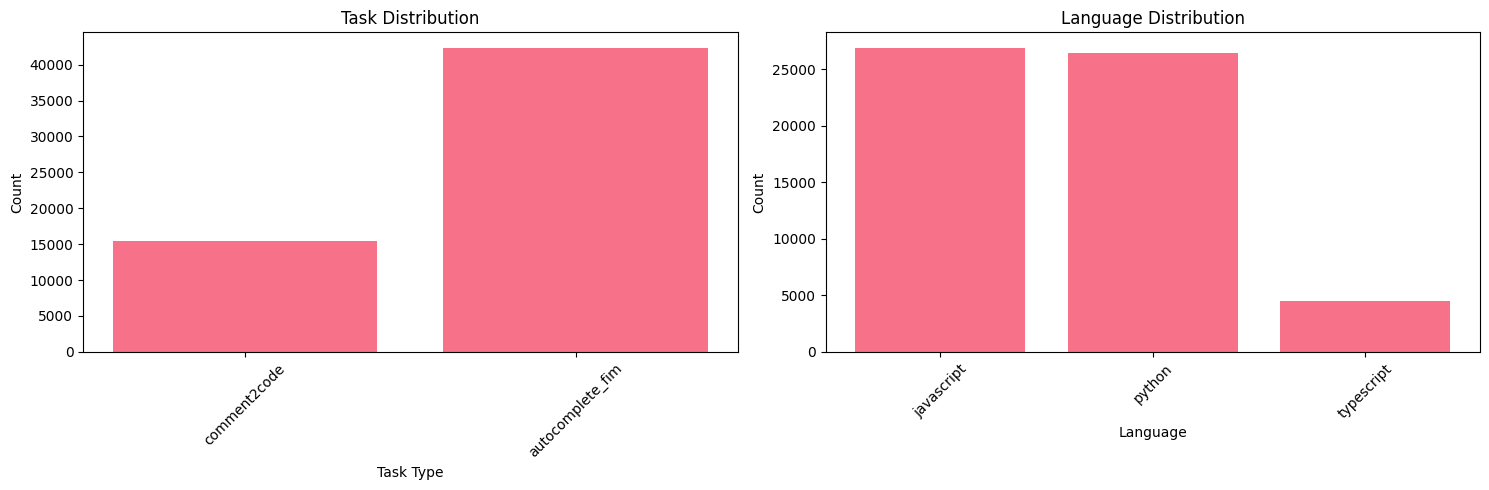


Example FIM sample:
<|fim_prefix|>def get_worker_node_ips(config_file, override_cluster_name):
    """Returns worker node IPs for given configuration file."""
<|fim_suffix|>
    try:
        nodes = provider.non_terminat...

Example comment-to-code sample:
// Write TypeScript/JavaScript code for the following comment
/**
Glide to drop-down menu
@this Blockly.Block
*/
function() {
    this.jsonInit({
      "message0": "%1",
      "args0": [
        {
   ...


In [27]:
# Analyze task distribution
task_counts = {}
for sample in train_data:
    task = sample.get('task', 'unknown')
    if task == 'unknown':
        print(sample)
        break
    task_counts[task] = task_counts.get(task, 0) + 1

print("Task distribution in training data:")
for task, count in task_counts.items():
    print(f"  {task}: {count:,} ({100*count/len(train_data):.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Task distribution
axes[0].bar(task_counts.keys(), task_counts.values())
axes[0].set_title('Task Distribution')
axes[0].set_xlabel('Task Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Language distribution
lang_counts = {}
for sample in train_data:
    lang = sample.get('language', 'unknown')
    lang_counts[lang] = lang_counts.get(lang, 0) + 1

axes[1].bar(lang_counts.keys(), lang_counts.values())
axes[1].set_title('Language Distribution')
axes[1].set_xlabel('Language')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Show example samples
print("\nExample FIM sample:")
fim_sample = next(s for s in train_data if s['task'] == 'autocomplete_fim')
print(fim_sample['text'][:200] + "...")

print("\nExample comment-to-code sample:")
c2c_sample = next(s for s in train_data if s['task'] == 'comment2code')
print(c2c_sample['text'][:200] + "...")
